# Local-Global-Trend(dlt) Example

dlt stands for Local and Global Trend, which is an important model type in orbit package. In the model equation, there is a local trend term and a global trend term.

**Note: Negative response values are not allowed in dlt model, due to the existence of the global trend term.**

In [1]:
import pandas as pd
import numpy as np
from orbit.models.dlt import DLTMAP, DLTAggregated, DLTFull
from orbit.diagnostics.plot import plot_predicted_data
from orbit.diagnostics.plot import plot_predicted_components
from orbit.utils.dataset import load_iclaims

## Data

*iclaims_example* is a dataset containing the weekly initial claims for US unemployment benefits against a few related google trend queries from Jan 2010 - June 2018. This aims to mimick the dataset from the paper "Predicting the Present with Bayesian Structural Time Series" by SCOTT and VARIAN (2014).

Number of claims are obtained from [Federal Reserve Bank of St. Louis](https://fred.stlouisfed.org/series/ICNSA) while google queries are obtained through [Google Trends API](https://trends.google.com/trends/?geo=US).

In [2]:
DATA_FILE = "./data/iclaims_example.csv"
df = load_iclaims()

date_col = 'week'
response_col = 'claims'
df.dtypes

week              datetime64[ns]
claims                     int64
trend.unemploy           float64
trend.filling            float64
trend.job                float64
dtype: object

We preprocess the data by log transformation to turn model from `additive` to `multiplicative`.

In [3]:
df[['claims', 'trend.unemploy', 'trend.filling', 'trend.job']] =\
    df[['claims', 'trend.unemploy', 'trend.filling', 'trend.job']].apply(np.log)

In [4]:
df.head(5)

,week,claims,trend.unemploy,trend.filling,trend.job
0,2010-01-03,13.386595,0.168876,-0.328309,0.113033
1,2010-01-10,13.624218,0.168876,-0.204695,0.164326
2,2010-01-17,13.398741,0.185136,-0.302334,0.113033
3,2010-01-24,13.137549,0.152346,-0.204695,0.102451
4,2010-01-31,13.196760,0.083354,-0.252323,0.070016


### Train / Test Split

In [5]:
test_size=52
train_df=df[:-test_size]
test_df=df[-test_size:]

In [6]:
train_df.head(5)

,week,claims,trend.unemploy,trend.filling,trend.job
0,2010-01-03,13.386595,0.168876,-0.328309,0.113033
1,2010-01-10,13.624218,0.168876,-0.204695,0.164326
2,2010-01-17,13.398741,0.185136,-0.302334,0.113033
3,2010-01-24,13.137549,0.152346,-0.204695,0.102451
4,2010-01-31,13.196760,0.083354,-0.252323,0.070016


## MAP Fit and Predict

In [8]:
dlt=DLTMAP(
    response_col=response_col,
    date_col=date_col,
    seasonality=52,
    seed=8888,
)

In [9]:
%%time
dlt.fit(df=train_df)

CPU times: user 126 ms, sys: 10.5 ms, total: 136 ms
Wall time: 388 ms


In [10]:
predicted_df = dlt.predict(df=test_df)

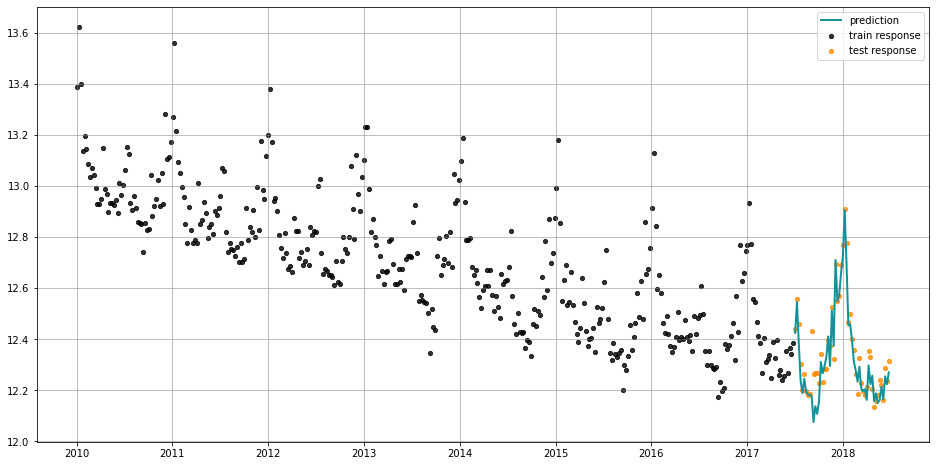

In [11]:
plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                    date_col=date_col, actual_col=response_col,  
                    test_actual_df=test_df)

## MCMC Fit and Predict

In [13]:
dlt=DLTFull(
    response_col=response_col,
    date_col=date_col,
    seasonality=52,
    seed=8888,
)

In [14]:
%%time
dlt.fit(df=train_df)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


CPU times: user 76.4 ms, sys: 71 ms, total: 147 ms
Wall time: 5.01 s


In [15]:
predicted_df = dlt.predict(df=test_df)

In [16]:
predicted_df.tail(5)

,week,prediction_5,prediction,prediction_95
47,2018-05-27,12.110832,12.236411,12.365385
48,2018-06-03,12.059123,12.178334,12.289549
49,2018-06-10,12.091117,12.275301,12.384388
50,2018-06-17,12.117888,12.241044,12.329424
51,2018-06-24,12.170938,12.299122,12.382156


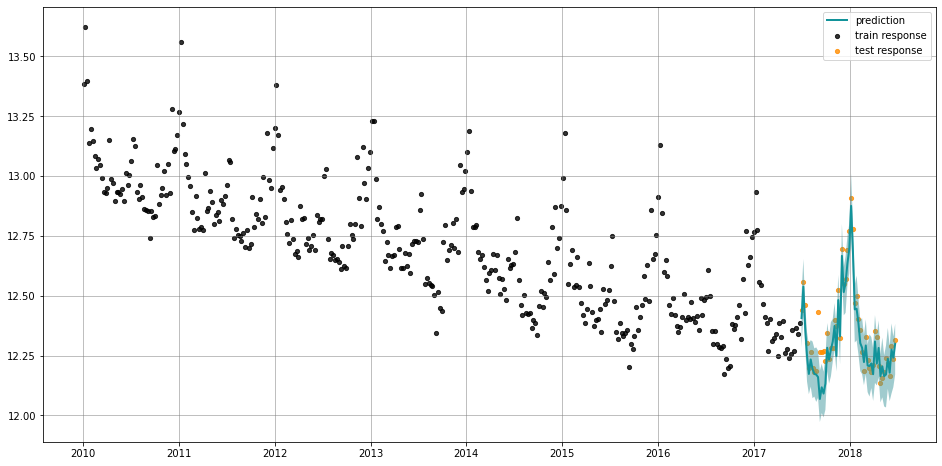

In [17]:
plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                    date_col=dlt.date_col, actual_col=dlt.response_col, 
                    test_actual_df=test_df)

## Fit with Regressors & Decmpose Prediction

### Fit with regressors

In [19]:
dlt=DLTFull(
    response_col=response_col,
    regressor_col=['trend.unemploy', 'trend.filling'],
    date_col='week',
    seasonality=52,
    seed=8888,
)

In [20]:
%%time
dlt.fit(df=train_df)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


CPU times: user 90 ms, sys: 79.6 ms, total: 170 ms
Wall time: 5.23 s


### Decompose Prediction

We can use `decompose=True` to decompose prediction into `trend`, `seasonality` and `regression` components. This command only works with point estimate.

In [21]:
# make prediction in both train and test period
predicted_df = dlt.predict(df=df, decompose=True)
predicted_df.tail(5)

,week,prediction_5,prediction,prediction_95,trend_5,trend,trend_95,seasonality_5,seasonality,seasonality_95,regression_5,regression,regression_95
438,2018-05-27,12.103335,12.221907,12.307488,12.103427,12.236772,12.337020,-0.047126,-0.016577,0.011866,-0.000232,0.001618,0.003346
439,2018-06-03,12.029615,12.158781,12.277283,12.083645,12.232395,12.363934,-0.112103,-0.078379,-0.052343,0.002657,0.004568,0.006972
440,2018-06-10,12.166777,12.268834,12.360456,12.129363,12.242133,12.353784,-0.014462,0.017583,0.040870,0.006122,0.014262,0.021104
441,2018-06-17,12.117507,12.235557,12.330714,12.087887,12.233547,12.349272,-0.043775,-0.009943,0.015418,0.004875,0.012716,0.018558
442,2018-06-24,12.151689,12.269709,12.379658,12.094159,12.229236,12.352538,-0.001604,0.029410,0.055974,0.006751,0.013830,0.020018


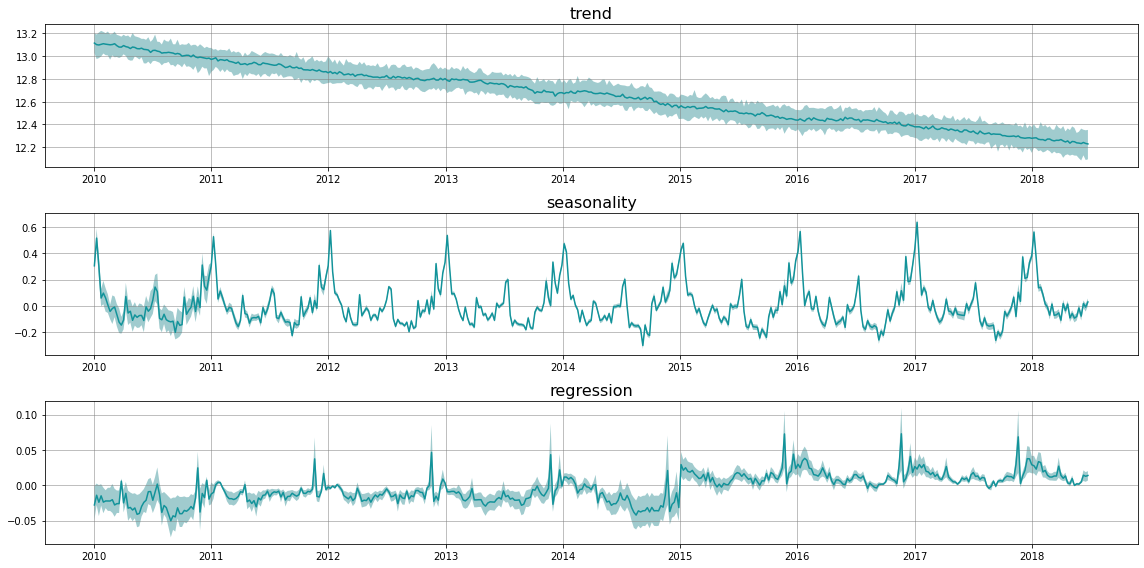

In [22]:
plot_predicted_components(predicted_df=predicted_df, date_col=date_col)